In [1]:
# this file is to update weights of 3x3 patterns
# chemical naming: AHL is the same as OC6, CHL is the same as OHC14

In [2]:
from numpy.random import RandomState
import numpy as np
np.set_printoptions(precision=2,suppress=True)

import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import *

from scipy.optimize import basinhopping,minimize,differential_evolution

In [4]:
# basis functions, phi_pos, phi_neg
def transf_pos(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym*((x/K)**n)/(1+(x/K)**n)+ym*y0
    return result

def transf_neg(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym/(1+(x/K)**n)+y0*ym
    return result

#------------
# added during revision

def quant(data,levels):
    results=[]
    for i in range(0,len(data)):
        ind=np.argmin(abs(data[i]-np.array(levels)))
        results.append(levels[ind])
    return results


def wt_update(w,h,err_sign,levels):
    # h is a hidden variable
    w_=w.copy()
    for i in range(0,len(w)):
        indx_=levels.index(w[i])
        
        if err_sign[i]>0 and indx_<len(levels)-1:
            if h[i]>levels[indx_+1]:
                w_[i]=levels[indx_+1]
                
        if err_sign[i]<0 and indx_>0:
            if h[i]<levels[indx_-1]:
                w_[i]=levels[indx_-1]       
    return w_

In [5]:
# define 3x3 patterns 

zv=[1,1,0,0,1,0,0,1,1]
vv=[1,0,1,1,0,1,0,1,0]
nv=[0,1,0,1,0,1,1,0,1]

def noisy(vector):
    result=[]
    for i in range(0,len(vector)):
        v=vector.copy()
        v[i]=np.logical_not(vector[i]).astype(int)
        #print(i,vector[i],v[i])
        result.append(v)
    return result

zpatterns=([zv]+noisy(zv))
vpatterns=([vv]+noisy(vv))
npatterns=([nv]+noisy(nv))

start=0
end=10
patterns=zpatterns[start:end]+vpatterns[start:end]+npatterns[start:end]
patterns_complete=zpatterns+vpatterns+npatterns

lenth=end-start

In [6]:
# define global varaibles

size=3*3
target_L=0.0
target_H=1.2
patterns=patterns

lenth=int(len(patterns)/3)

target_0=np.array([target_H]*lenth+[target_L]*lenth+[target_L]*lenth)
target_1=np.array([target_L]*lenth+[target_H]*lenth+[target_L]*lenth)
target_2=np.array([target_L]*lenth+[target_L]*lenth+[target_H]*lenth)

target=target_0
#----
AHL_unit_level=33# uM 
transf_p=np.zeros(2)
transf_n=np.zeros(2)

# parameter numbers are approximated from values in Table 1
transf_p[0]=transf_pos(x=0,K=50,y0=0.1,ym=1.0,n=0.45)
transf_p[1]=transf_pos(x=AHL_unit_level,K=50,y0=0.1,ym=1.0,n=0.45)

# transf_n paramters are from Table 1
transf_n[0]=transf_neg(x=0,K=0.252,y0=0.341,ym=1,n=0.67)
transf_n[1]=transf_neg(x=AHL_unit_level,K=0.252,y0=0.341,ym=1,n=0.67)

phi_pos=np.array([transf_p]*size)
phi_neg=np.array([transf_n]*size)

In [7]:
def examine_output(w,P,phi_pos,phi_neg):
    y_n=np.zeros(len(P))
    w_ph_=np.zeros(len(P))

    for n in range(0,len(P)):
        pttn=np.array(P[n])
        
        phi_nw=get_phinw(w,pttn,phi_pos,phi_neg)
                
        w_ph_[n]=np.dot(w,phi_nw)/len(w)
        y_n[n]=activate(w_ph_[n])
        
    return y_n,w_ph_

def output_fcn(pttn,fcn):
    
    CHL_levels=np.zeros(len(pttn))
    for i in range(0,len(pttn)):
        CHL_levels[i]=fcn[i][pttn[i]]
        
    return CHL_levels

def activate(x):
    K,y0,ym_x,n= 1.10292919e+03,1.94584842e-02,2.15950963e+04,2.33038211e+00
    result=transf_pos(x.sum(),K=K,y0=y0/1e4,ym=2.0,n=n).sum()
    return result

def get_phinw(w,pttn,phi_pos,phi_neg):
    # conitnuous means wether negative weights are allowed to vary
    phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
            (w/np.sqrt(w**2)-1)/2*output_fcn(pttn,phi_neg)

    return phi_nw

In [8]:
# cont_ sets if negative weights are allowed to vary. By default cont_=False, only one possible negative weight. 
# initial case all negative weights actually work better, 
    # otherwise can lead to spikes in weights and error values
# if case cont_=True, initial all positive weights work best
    
def train_step1(target,size,eta,phi_pos,phi_neg,pos=False,cont_=False):
    rndstate=RandomState(2)
    
    if cont_==True or pos==True:
        h=rndstate.random_sample(size)
    else:
        h=rndstate.random_sample(size)*(-1)
        
    print('h: ',h)
    r=size

    w_series=[]
    y_series=[]
    delta_series=[]

    for it in range(0,300):
        y_n=np.zeros(len(patterns))
        g_n=np.zeros(len(patterns))
        delta_err=np.zeros(size)
        phi_n=[]
      
        w=h.copy()   
        if cont_==False:
            w[w<0]=-735
        
        if pos==True:
            w[w<0]=0.1
            
        for n in range(0,len(patterns)):
            pttn=np.array(patterns[n])
            # consider pttn as indexes in vector x, 0 means x[0], 1 means x[1]
            
            phi_nw=get_phinw(w,pttn,phi_pos,phi_neg)
            # h is the hidden variable
            g_n[n]=np.dot(w,phi_nw)/r
            y_n[n]=activate(g_n[n])            
            
            tmp=(y_n[n]-target[n])
            tmp=min(target_H,tmp)
            delta_err+=tmp*phi_nw

        w_series.append(w)
        h=h-eta*delta_err 
        y_series.append(y_n)
        delta_series.append(delta_err)
        
    return w,y_series,w_series,delta_series

In [11]:
# step2
# basinhopping method

def step2(w0):
    y=np.zeros(len(patterns))

    for n in range(0,len(patterns)):
        pttn=np.array(patterns[n])
        phi_nw=get_phinw(w,pttn,phi_pos,phi_neg)
        
        w0[w0<0]=-735
        y[n]=activate(np.dot(w0,phi_nw)/size)
                
    product=(2*y-target_H)*(2*target-target_H)
    
    return np.var(product)*10+(target_H**2-np.mean(product))

In [10]:
w0,y0_sc,w0_sc,d0_sc=train_step1(target_0,9,eta=10,phi_pos=phi_pos,phi_neg=phi_neg,cont_=False)
w1,y1_sc,w1_sc,d1_sc=train_step1(target_1,9,eta=10,phi_pos=phi_pos,phi_neg=phi_neg,cont_=False)
w2,y2_sc,w2_sc,d2_sc=train_step1(target_2,9,eta=10,phi_pos=phi_pos,phi_neg=phi_neg,cont_=False)


h:  [-0.44 -0.03 -0.55 -0.44 -0.42 -0.33 -0.2  -0.62 -0.3 ]
h:  [-0.44 -0.03 -0.55 -0.44 -0.42 -0.33 -0.2  -0.62 -0.3 ]
h:  [-0.44 -0.03 -0.55 -0.44 -0.42 -0.33 -0.2  -0.62 -0.3 ]


In [13]:
# demo example of step2, w0;
# output is the same as in Table S4; 

w=w0
target=target_0
minimizer_kwargs = {"method": "Nelder-Mead"}
res0=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res0.lowest_optimization_result.success)
w0_txt=", ".join("%.0f" % f for f in res0.x)
print('step2 w0: ',w0_txt)

True
step2 w0:  1813, 1813, -735, -735, 2872, -735, -735, 1813, 1813


In [15]:
# demo example of step2, w1

w=w1
target=target_1
minimizer_kwargs = {"method": "Nelder-Mead"}
res1=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res1.lowest_optimization_result.success)
w1_txt=", ".join("%.0f" % f for f in res1.x)
print('step2 w1: ',w1_txt)

True
step2 w1:  1813, -735, 2872, 1813, -735, 1813, -735, 1813, -735


In [16]:
# demo example of step2, w2

w=w2
target=target_2
minimizer_kwargs = {"method": "Nelder-Mead"}
res2=basinhopping(step2,w,minimizer_kwargs=minimizer_kwargs,niter=20)

print(res2.lowest_optimization_result.success)
w2_txt=", ".join("%.0f" % f for f in res2.x)
print('step2 w1: ',w2_txt)

True
step2 w1:  -735, 1813, -735, 1813, -735, 1813, 2872, -735, 1813


In [18]:
# algorithm to update discrete weights
# all initial states start with negative weights

def train_step1_dt(target,size,eta,phi_pos,phi_neg,wt_levels):

    h=np.ones(size)*wt_levels[0]
    w=h.copy()
    #print('w: ',w)
    r=size

    w_series=[]
    y_series=[]
    delta_series=[]
        
    for it in range(0,300):
        y_n=np.zeros(len(patterns))
        g_n=np.zeros(len(patterns))
        delta_err=np.zeros(size)
        for n in range(0,len(patterns)):
            pttn=np.array(patterns[n])
        
            phi_nw=get_phinw(w,pttn,phi_pos,phi_neg)

            g_n[n]=np.dot(w,phi_nw)/r
            y_n[n]=activate(g_n[n])            
            tmp=(y_n[n]-target[n])
            tmp=min(target_H,tmp)            
            delta_err+=tmp*phi_nw
            
        y_series.append(y_n)
        w_series.append(w)
        delta_series.append(delta_err)
        h=h-eta*delta_err
        w=wt_update(w,h,-np.sign(delta_err),wt_levels)
        
    p_=(2*np.array(y_series)-target_H)*(2*target-target_H)
    pm_=np.var(p_,axis=1)*10+(target_H**2-np.mean(p_,axis=1))
    
    w=w_series[np.argmin(pm_)]
    y=y_series[np.argmin(pm_)]
    
    return w,y

In [19]:
# demo of weight update using discrete weights
# classification using two states

wt_levels=[-735.0,1906.0]
w0,y0=train_step1_dt(target_0,9,eta=20,phi_pos=phi_pos,phi_neg=phi_neg,wt_levels=wt_levels)
w1,y1=train_step1_dt(target_1,9,eta=20,phi_pos=phi_pos,phi_neg=phi_neg,wt_levels=wt_levels)
w2,y2=train_step1_dt(target_2,9,eta=20,phi_pos=phi_pos,phi_neg=phi_neg,wt_levels=wt_levels)

(0.0, 1.2)

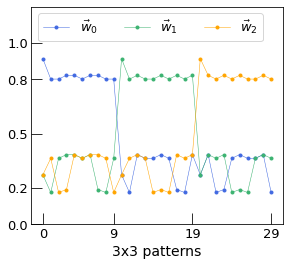

In [20]:
# Fig S5 demo
fig=plt.figure(figsize=(4.5,4))
ax=fig.add_subplot(111)

ax.plot(y0,c='royalblue',marker='.',lw=0.5,label='$\\vec{w}_0$')
ax.plot(y1,c='mediumseagreen',marker='.',lw=0.5,label='$\\vec{w}_1$')
ax.plot(y2,c='orange',marker='.',lw=0.5,label='$\\vec{w}_2$')

ax.tick_params(axis='both',direction='in',labelsize=13,size=11)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('3x3 patterns',fontsize=14)
ax.legend(loc='upper left',ncol=3,fontsize=13)
ax.set_xticks([0,9,19,29])

plt.ylim([0,1.2])
